# Setup

In [1]:
import cm1_load_utils as cl
import load_ppe_fun as lp
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from time import sleep
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm
import itertools
import util_fun as uf

In [3]:
nikki = ''
target_nikki = 'target'
sim_config = 'fullmp_actce'
target_sim_config = 'fullmp'

plot_dir = f"plots/{nikki}/{sim_config}/"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

n_init = 1
target_mp = 'BIN-TAU'
train_mp = 'SLC-BOSS'
mconfigs = os.listdir(cl.output_dir + nikki)
vars_strs, vars_vn = lp.get_dics(cl.output_dir, target_nikki, target_sim_config, n_init)
var_interest = []
# var_interest += ['M0_dmprof', 'M3_dmprof', 'M4_dmprof', 'M6_dmprof'] # domain-mean profiles
# var_interest += ['M0_dmpath', 'M3_dmpath', 'M4_dmpath', 'M6_dmpath'] # domain-mean path
var_interest += ['M0_last2hrmean', 'M3_last2hrmean', 'M4_last2hrmean', 'M6_last2hrmean', 'prate_dm_last2hrmean'] # domain-mean path
# var_interest += ['M0_curtain_mean', 'M3_curtain_mean', 'M4_curtain_mean', 'M6_curtain_mean'] # curtain
# var_interest += ['w', 'w_dmprof', 'w_curtain_slice', 'w_curtain_mean'] # 4D var
# var_interest += ['u_dmprof', 'v_dmprof', 'w_dmprof']
# var_interest += ['M0', 'M3']

file_info = {'dir': cl.output_dir, 
             'date': nikki,
             'vars_vn': vars_vn}

if 'nc_dict' not in globals():
    nc_dict = {}

# load target data

In [4]:
# import importlib
# importlib.reload(cl)

for initcond_combo in tqdm(itertools.product(*vars_strs), desc='loading BIN data'):
    ic_str = "".join(initcond_combo)
    file_info.update({'sim_config': target_sim_config,
                      'vars_str': list(initcond_combo),
                      'date': target_nikki,
                      'mp_config': target_mp})
    cl.load_cm1(file_info, var_interest, nc_dict, False)

loading BIN data: 0it [00:00, ?it/s]

loading BIN data: 7it [00:06,  1.10it/s]


# load PPE data

In [5]:
# load BOSS data
file_info.update({'sim_config': sim_config,
                    'date': nikki,
                    'mp_config': train_mp})
ppe_idx = cl.get_ppe_idx(file_info)
ppe_idx = [int(i) for i in ppe_idx]
ppe_idx = ppe_idx
for ippe in tqdm(ppe_idx, desc='loading BOSS data'):
    cl.load_cm1(file_info, var_interest, nc_dict, True, ippe=ippe)

loading BOSS data: 100%|██████████| 50/50 [00:19<00:00,  2.53it/s]


# visualize

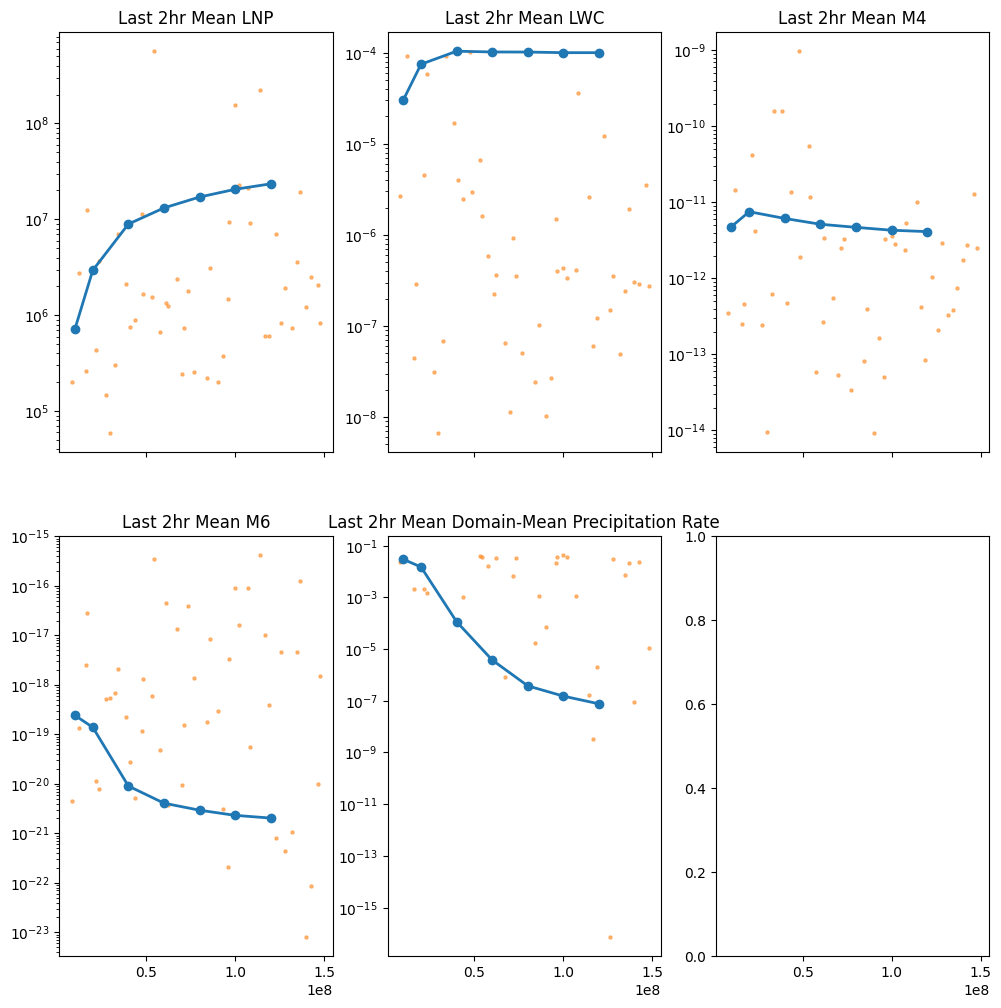

In [6]:
fig, axs = plt.subplots(2, 3, figsize=(12, 12), sharex=True)
axs = axs.flatten()
na = []
for initcond_combo in itertools.product(*vars_strs):
    ic_str = "".join(initcond_combo)
    na.append(nc_dict[ic_str]['BIN-TAU']['na'])

na = np.array(na)

for ivar, var_name in enumerate(var_interest):
    tgt_data = []
    train_data = []
    na_train = []
    for initcond_combo in itertools.product(*vars_strs):
        ic_str = "".join(initcond_combo)
        tgt_data.append(nc_dict[ic_str]['BIN-TAU'][var_name]['value'])
    for ippe in ppe_idx:
        ippe = int(ippe)
        train_data.append(nc_dict['cic']['SLC-BOSS'][ippe][var_name]['value'])
        na_train.append(nc_dict['cic']['SLC-BOSS'][ippe]['na'])
    tgt_data = np.array(tgt_data)
    train_data = np.array(train_data)
    na_train = np.array(na_train)
    axs[ivar].plot(na, tgt_data, label=ic_str, linewidth=2, marker='o')
    axs[ivar].scatter(na_train, train_data, label=ic_str, s=5, color='tab:orange', alpha=0.5)
    axs[ivar].set_title(cl.output_var_set[var_name]['longname'])
    axs[ivar].set_yscale('log')

plt.savefig(f"{plot_dir}{sim_config}_dm_path.png")